In [16]:
import os
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

data_dir_1 = '/workspaces/Final-Year-Project/Data/2023/'
file_list = os.listdir(data_dir_1)
sas_files = [file for file in file_list if file.endswith('.XPT') or file.endswith('.xpt')]

first_file_path = os.path.join(data_dir_1, sas_files[0])
merged_df = pd.read_sas(first_file_path, format='xport', encoding='iso-8859-1')

for file_name in sas_files[1:]:
    file_path = os.path.join(data_dir_1, file_name)
    df = pd.read_sas(file_path, format='xport', encoding='iso-8859-1')
    if 'SEQN' not in df.columns:
        continue  # Skip files missing SEQN
    merged_df = pd.merge(merged_df, df, on='SEQN', how='outer', suffixes=('', f'_{file_name}'))
    del df  # Free memory

# Mapping categorical values to numeric values
def encode_pad_values(value):
    mapping = {'D': 1, 'M': 2, 'W': 3, 'Y': 4}
    return mapping.get(value, None)  # Return None if value is not in the mapping

# Assuming merged_df is already loaded
# Apply the encoding to the 'PAD790U' and 'PAD810U' columns
merged_df['PAD790U'] = merged_df['PAD790U'].apply(encode_pad_values)
merged_df['PAD810U'] = merged_df['PAD810U'].apply(encode_pad_values)

merged_df = merged_df.select_dtypes(include=['float64', 'int64'])

#save to csv
merged_df.to_csv('/workspaces/Final-Year-Project/Cleaned Data/AllMergedData.csv', index=False)

# count how many rows there are in the dataset
print(merged_df.shape)

(11933, 318)


In [17]:
merged_df_cleaned = merged_df[merged_df['RIDSTATR'] == 2]

def categorize_diabetes(row):    
    if (pd.notnull(row['LBXGH']) and row['LBXGH'] >= 5.7) or (pd.notnull(row['LBXGLU']) and row['LBXGLU'] >= 100):
        return 1  # Diabetes / At Risk
    else:
        return 0  # No Diabetes

merged_df_cleaned['Diabetes Status'] = merged_df_cleaned.apply(categorize_diabetes, axis=1)


merged_df_cleaned = merged_df_cleaned.dropna(subset=['Diabetes Status'])
merged_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8860 entries, 0 to 11932
Columns: 319 entries, SEQN to Diabetes Status
dtypes: float64(318), int64(1)
memory usage: 21.6 MB


/tmp/ipykernel_3665/1569237287.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_cleaned['Diabetes Status'] = merged_df_cleaned.apply(categorize_diabetes, axis=1)


In [18]:
df = merged_df_cleaned

missing_percentage = df.isnull().mean() * 100

columns_to_drop = missing_percentage[missing_percentage > 15].index
df = df.drop(columns=columns_to_drop)

df = df.dropna(axis=0)
#df = df.dropna(thresh=len(df.columns) * 0.9)

# Drop rows where any column contains the value 9
df = df[~df.isin ([9,99,999,9999,99999]).any(axis=1)]

df['Diabetes Status'].value_counts()


Diabetes Status
0    2445
1    1816
Name: count, dtype: int64

In [19]:
no_diabetes = df[df['Diabetes Status'] == 0]
diabetes = df[df['Diabetes Status'] == 1]

minority_class_size = min(len(no_diabetes), len(diabetes))

no_diabetes_downsampled = resample(no_diabetes, replace=False, n_samples=minority_class_size, random_state=42)
diabetes_downsampled = resample(diabetes, replace=False, n_samples=minority_class_size, random_state=42)

df_balanced = pd.concat([no_diabetes_downsampled, diabetes_downsampled])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df_balanced.to_csv('/workspaces/Final-Year-Project/Cleaned Data/BalancedData.csv', index=False)

df_balanced['Diabetes Status'].value_counts()  



Diabetes Status
0    1816
1    1816
Name: count, dtype: int64

In [20]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3632 entries, 0 to 3631
Data columns (total 45 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SEQN             3632 non-null   float64
 1   IMQ011           3632 non-null   float64
 2   SDDSRVYR         3632 non-null   float64
 3   RIDSTATR         3632 non-null   float64
 4   RIAGENDR         3632 non-null   float64
 5   RIDAGEYR         3632 non-null   float64
 6   RIDRETH1         3632 non-null   float64
 7   RIDRETH3         3632 non-null   float64
 8   RIDEXMON         3632 non-null   float64
 9   DMDBORN4         3632 non-null   float64
 10  DMDHHSIZ         3632 non-null   float64
 11  WTINT2YR         3632 non-null   float64
 12  WTMEC2YR         3632 non-null   float64
 13  SDMVSTRA         3632 non-null   float64
 14  SDMVPSU          3632 non-null   float64
 15  INDFMPIR         3632 non-null   float64
 16  HIQ011           3632 non-null   float64
 17  HIQ210        

In [21]:

df_balanced.shape

(3632, 45)

Text(0.5, 1.0, 'Correlation Matrix')

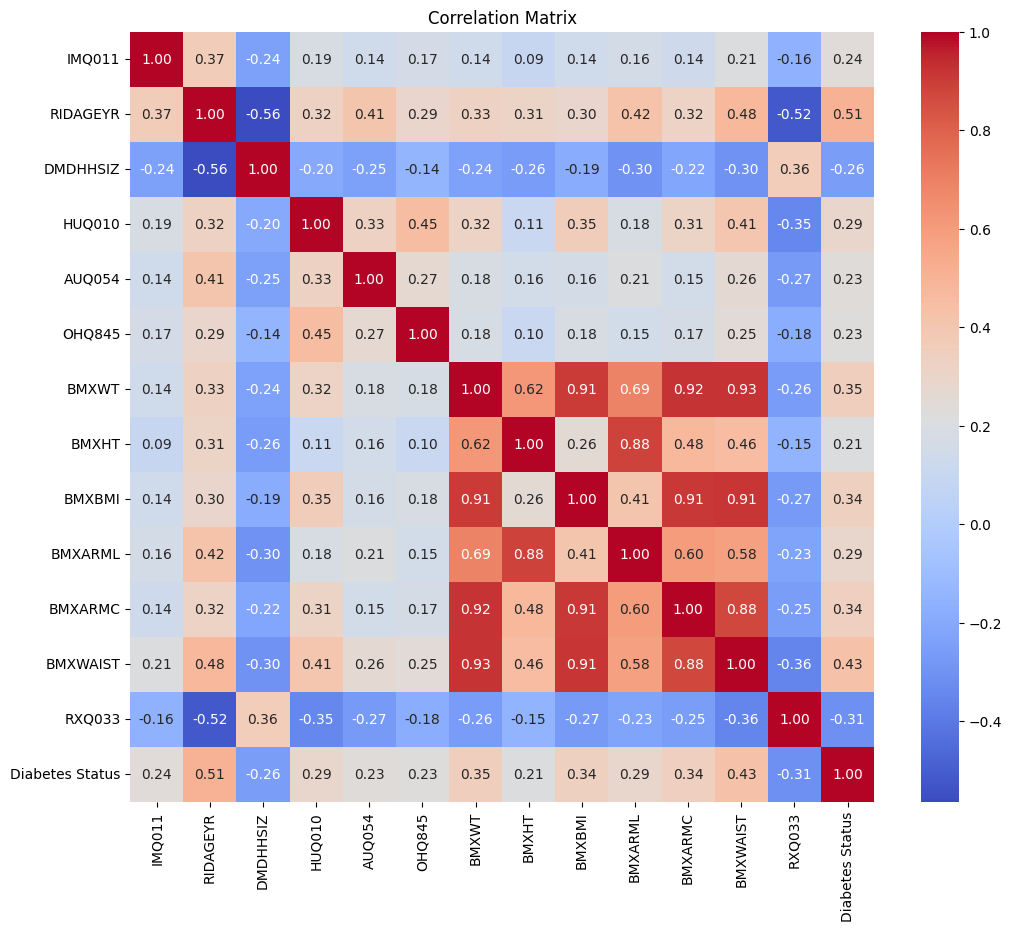

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

df_corr = df_balanced.corr()

df_top_filtered = df_corr['Diabetes Status'].abs()[df_corr['Diabetes Status'].abs() > 0.20]

columns_to_keep = df_top_filtered.index
df_filtered = df_balanced[columns_to_keep]

plt.figure(figsize=(12, 10))

sns.heatmap(df_filtered.corr(), annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix')

In [23]:
df_filtered.shape

(3632, 14)

In [24]:
df_train_test, df_validate = train_test_split(df_filtered, test_size=0.1, random_state=42)

df_filtered.to_csv('/workspaces/Final-Year-Project/Cleaned Data/DataTopCorrelationData.csv', index=False)
df_validate.to_csv('/workspaces/Final-Year-Project/Cleaned Data/ValidationData.csv', index=False)
df_train_test.to_csv('/workspaces/Final-Year-Project/Cleaned Data/TrainTestData.csv', index=False)

print("Final Diabetes Status Distribution:\n", df_train_test['Diabetes Status'].value_counts())
print("Final Dataset Info:\n")
df_train_test.info()

Final Diabetes Status Distribution:
 Diabetes Status
0    1638
1    1630
Name: count, dtype: int64
Final Dataset Info:

<class 'pandas.core.frame.DataFrame'>
Index: 3268 entries, 1352 to 3174
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   IMQ011           3268 non-null   float64
 1   RIDAGEYR         3268 non-null   float64
 2   DMDHHSIZ         3268 non-null   float64
 3   HUQ010           3268 non-null   float64
 4   AUQ054           3268 non-null   float64
 5   OHQ845           3268 non-null   float64
 6   BMXWT            3268 non-null   float64
 7   BMXHT            3268 non-null   float64
 8   BMXBMI           3268 non-null   float64
 9   BMXARML          3268 non-null   float64
 10  BMXARMC          3268 non-null   float64
 11  BMXWAIST         3268 non-null   float64
 12  RXQ033           3268 non-null   float64
 13  Diabetes Status  3268 non-null   int64  
dtypes: float64(13), int64(1)
memory us

IMQ011 = Recieved Hepatitis Vaccine

RIDAGEYR = Age

DMDHHSIZ = Total Number Of People In Household

HUQ010 = Self Perceived Health

AUQ054 = General Condtion of Hearing

OHQ845 = Self Rating of Teeth and Gum Health

BMXWT = Weight KG

BMXHT = Height CM

BMXBMI = BMI

BMXARML = Arm Length CM

BMXARMC = Arm Circumfrence CM

BMXWAIST = Waist Circumference CM

RXQ033 = Taken prescription medication in last 30 days 

In [25]:
# Get the correlation values with 'Diabetes Status' and sort them in descending order
top_correlating_variables = df_corr['Diabetes Status'].abs().sort_values(ascending=False)

# Filter out 'Diabetes Status' from the list
top_correlating_variables = top_correlating_variables[top_correlating_variables.index != 'Diabetes Status']

# Display the sorted list of top correlating variables
top_correlating_variables


RIDAGEYR    0.507282
BMXWAIST    0.429667
BMXWT       0.347653
BMXARMC     0.341747
BMXBMI      0.337812
RXQ033      0.310339
BMXARML     0.287958
HUQ010      0.285452
DMDHHSIZ    0.258592
IMQ011      0.239891
AUQ054      0.231266
OHQ845      0.225087
BMXHT       0.208711
DMDBORN4    0.087956
RIAGENDR    0.072007
HUQ055      0.058138
OHQ620      0.053694
WTMEC2YR    0.050691
PUQ100      0.043255
HOD051      0.043076
HUQ090      0.042783
HUQ042      0.040113
INDFMMPC    0.037454
PUQ110      0.031992
MCQ053      0.031139
SDMVPSU     0.026518
RIDEXMON    0.026492
HEQ010      0.026382
BMDSTATS    0.025921
SEQN        0.021687
WTINT2YR    0.018337
SMD460      0.016478
RIDRETH1    0.015043
AGQ030      0.013524
SDMVSTRA    0.011176
HIQ210      0.007592
HUQ030      0.006797
INDFMPIR    0.002824
INQ300      0.001096
RIDRETH3    0.000988
MCQ010      0.000702
SDDSRVYR         NaN
RIDSTATR         NaN
HIQ011           NaN
Name: Diabetes Status, dtype: float64